# Clonal analysis and visualization notebook
Sendra et al. 2025 Dev Cell

## Import python libraries

In [ ]:
# Import plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, to_rgb

import seaborn as sns

# Import data science libraries
import numpy as np
import pandas as pd

# Import file managing libraries
import os
import sys

# Import statistics libraries
from scipy.stats import chisquare, ks_2samp, chi2_contingency
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from statsmodels.stats.multitest import multipletests
from itertools import combinations_with_replacement

## Define relative paths to data, results, figures and custom modules (functions for analysis and plotting made for this Repository)


In [2]:
# paths to data
combined_path = r'../data/All_techniques_clonal_analysis.xlsx'

# output dirs
out = r'../figures'
results = r'../results'

# modules (other functions) path
scripts = r'../scripts'

# Add the scripts folder to the Python path
sys.path.append(scripts)

from clonalpy import contribution_heatmap


## Define standard colors and plotting style

In [3]:
# Define list of colors for CM, ECr, EmM, EmEt, ExEt and ExM celltypes
colors = ['lightcoral', 'limegreen', 'khaki', 'forestgreen', 'mediumseagreen', 'thistle']

# Choose main columns to plot contribution heatmap
columns_to_plot = ['CM', 'EC', 'EmM', 'EmEt', 'ExEt', 'ExM']

# Prepare subtype colors and DataFrame
subtype_colors = {
    'AsM': '#96B0BC', 'SHF': '#A1732A', 'SM': '#198441',
    'Head': '#F0A7CA', 'Somi': '#999999'
}
subtypes_columns = ['AsM', 'SHF', 'SM', 'Head', 'Somi']

# Set Seaborn style
sns.set_style('ticks')

# Configure matplotlib parameters
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Helvetica'
mpl.rcParams['font.size'] = 15
plt.rcParams['xtick.labelsize']= 12
plt.rcParams['ytick.labelsize']= 12
plt.rcParams['axes.labelsize']= 13
plt.rcParams['axes.titlesize']= 13
mpl.rcParams.update({'figure.autolayout': True})
mpl.rcParams['figure.figsize'] = (4, 3)  # Adjust the figure size
markersize = 6  # Define a markersize variable for consistency

## Import data

In [4]:
combined = pd.read_excel(combined_path)

## 1. Retrospective clonal analysis
Using our stage estimation system, we ordered clones chronologically along with
their cellular contributions, which we had previously analyzed using
whole–mount confocal microscopy. As expected, earlier inductions
produced clones that contributed to several mesodermal compartments, including extraembryonic
tissues, while later inductions contributed to more restricted locations.
Surprisingly, only two of the unspecified clones contributed exclusively to CM and
EC, while most of them also contained cells outside the primitive heart tube. While fully specified clones dated after Late Streak stages (∼E7.0), earlier inductions
yielded multipotent clones containing also cells outside the heart.

In [5]:
# Select the data from Tamoxifen injections to examine the distribution of CM/EC clones
df = combined[combined['technique'] == "Tamoxifen"]

### Figure 1D
Distribution of CM/ECr clones along estimated recombination stage

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


Ks_2sampResult(statistic=0.3989769820971867, pvalue=0.06620260488271723)
Ks_2sampResult(statistic=0.8260869565217391, pvalue=0.0009641699296871753)
Ks_2sampResult(statistic=0.4803921568627451, pvalue=0.19488444431236218)


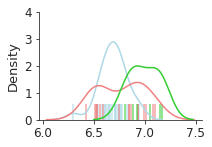

In [6]:
# Filter conditions
conditions = {
    'both_positive': (df['CM'] > 0) & (df['EC'] > 0),
    'only_cm_positive': (df['CM'] > 0) & (df['EC'] == 0),
    'only_ec_positive': (df['EC'] > 0) & (df['CM'] == 0)
}

# Subset data
filtered_data = {key: df[condition] for key, condition in conditions.items()}

# Plot KDE distribution
plt.figure(figsize=(3.2, 2.3))

# Colors for the conditions
kde_colors = ['lightblue', colors[0], colors[1]]

# Plot KDE and rugplots for each condition
for idx, (key, data) in enumerate(filtered_data.items()):
    sns.kdeplot(data['estimated_recombination_stage_divisions'], color=kde_colors[idx])
    sns.rugplot(data['estimated_recombination_stage_divisions'], height=0.15, 
                color=kde_colors[idx], linewidth=1.5, alpha=0.7)

# Customize the plot
plt.xlabel('')
plt.ylabel('Density')
plt.ylim(0, 4)

# Hide the right and top spines
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Save the plot
plt.tight_layout()
plt.savefig(f"{out}/estimated_recombination_stage_divisions.png")
plt.savefig(f"{out}/estimated_recombination_stage_divisions.svg")

# Test statistical differences between distributions
for group1, group2 in [('both_positive', 'only_cm_positive'), 
                       ('both_positive', 'only_ec_positive'), 
                       ('only_cm_positive', 'only_ec_positive')]:
    stat_test = ks_2samp(filtered_data[group1]['estimated_recombination_stage_divisions'], 
                         filtered_data[group2]['estimated_recombination_stage_divisions'])
    print(stat_test)


### Figure 1E
Proportion of bilateral clones in each category CM/ECr clones.

Chi-square test between 'Both Positive' and 'Only CM or EC Positive':
Chi2: 3.56, p-value: 0.06



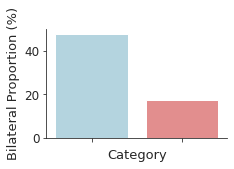

In [7]:
# Combine "Only CM Positive" and "Only EC Positive" into a single category
only_cm_ec_positive = pd.concat([filtered_data['only_cm_positive'], filtered_data['only_ec_positive']])

# Recalculate counts for the new categories
def count_bilateral(data):
    return (data['bilateral'] == "YES").sum(), (data['bilateral'] != "YES").sum()

# Bilateral counts for each category
bilateral_counts = {
    'Both Positive': count_bilateral(filtered_data['both_positive']),
    'Only CM or EC Positive': count_bilateral(only_cm_ec_positive)
}

# Calculate the total number of rows in each category (also including the new 'Only CM or EC Positive' category)
total_counts = {
    'Both Positive': len(filtered_data['both_positive']),
    'Only CM or EC Positive': len(only_cm_ec_positive)
}

# Calculate the proportion of bilateral rows in each category
bilateral_proportions = {
    key: (bilateral_counts[key][0] / total_counts[key]) * 100 for key in bilateral_counts
}

# dfate a DataFrame for plotting
bilateral_df = pd.DataFrame(list(bilateral_proportions.items()), columns=['Category', 'Bilateral Proportion (%)'])

# Define a function to perform the chi-square test
def chi_square_test(category1, category2):
    contingency_table = [
        [bilateral_counts[category1][0], bilateral_counts[category1][1]],
        [bilateral_counts[category2][0], bilateral_counts[category2][1]]
    ]
    chi2, p, _, _ = chi2_contingency(contingency_table)
    return chi2, p

# Perform the chi-square test between the two categories
chi2, p = chi_square_test('Both Positive', 'Only CM or EC Positive')

# Print results
print(f"Chi-square test between 'Both Positive' and 'Only CM or EC Positive':")
print(f"Chi2: {chi2:.2f}, p-value: {p:.2f}\n")

# Plotting the bar plot
plt.figure(figsize=(3.5, 2.6))
ax = sns.barplot(data=bilateral_df, x='Category', y='Bilateral Proportion (%)', palette=['lightblue', colors[0]])

# Customize plot appearance
ax.set_xticklabels([])
ax.set_ylabel('Bilateral Proportion (%)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Finalize the plot layout
plt.tight_layout()
plt.xticks(rotation=45)

# Save the figure
plt.savefig(f"{out}/bilateral_proportions_grouped.png")
plt.savefig(f"{out}/bilateral_proportions_grouped.svg")


### Figure S1J
Heatmap of clonal contribution for retrospective clonal analysis, with colored squares for undifferentiated mesoderm subtypes

In [8]:
# Extract the main cell type columns (columns to plot)
clusters_summary = df[columns_to_plot].fillna(0)

# Extract undifferentiated mesoderm (EmM) subtype columns to plot as small squares on top of EmM category
subtypes_df = df[subtypes_columns].fillna(0)

# Normalize values to percentages
clusters_summary_norm = clusters_summary.div(clusters_summary.sum(axis=1), axis=0) * 100
clusters_summary_norm.replace(0, np.nan, inplace=True)

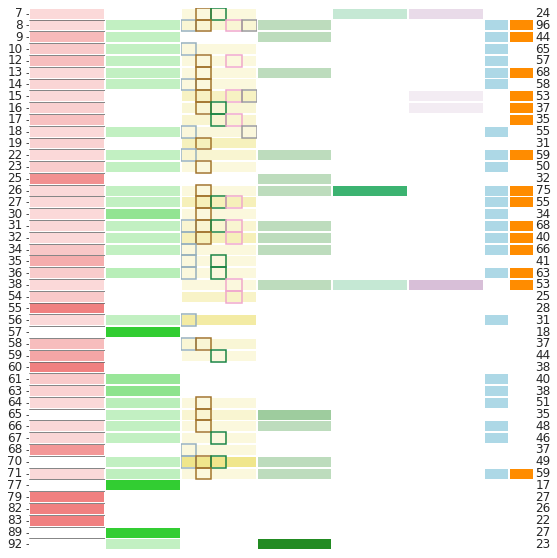

In [9]:
contribution_heatmap(clusters_summary_norm, subtypes_df, subtypes_columns, subtype_colors, df, colors, figsize=(8, 8))

## 2. Prospective Clonal analysis

In [10]:
# Select the data from Tamoxifen injections to examine the distribution of CM/EC clones
df = combined[combined['technique'] == "TAT-Cre"]

### Figure S2

In [11]:
# Extract the main cell type columns (columns to plot)
clusters_summary = df[columns_to_plot].fillna(0)

# Extract undifferentiated mesoderm (EmM) subtype columns to plot as small squares on top of EmM category
subtypes_df = df[subtypes_columns].fillna(0)

# Normalize values to percentages
clusters_summary_norm = clusters_summary.div(clusters_summary.sum(axis=1), axis=0) * 100
clusters_summary_norm.replace(0, np.nan, inplace=True)

C:\Users\msendra\AppData\Roaming\Python\Python36\site-packages\seaborn\matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\msendra\AppData\Roaming\Python\Python36\site-packages\seaborn\matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


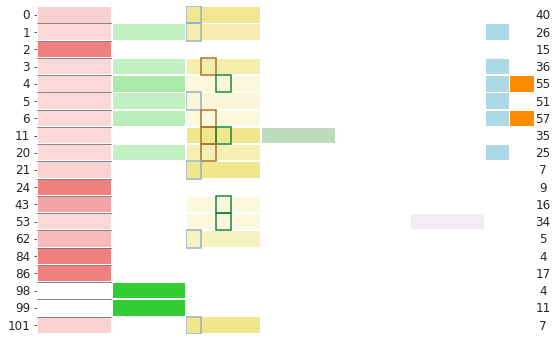

In [12]:
contribution_heatmap(clusters_summary_norm, subtypes_df, subtypes_columns, subtype_colors, df, colors, figsize=(8, 5))

### Figure 2C

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


Chi-square statistic: 11.411146019841674, p-value: 0.009698258856263327


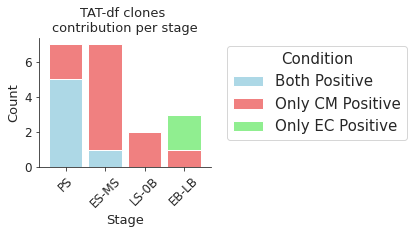

In [13]:
# Define stage mapping
stage_sorter = {'PS': 6.25, 'PS-ES': 6.5, 'ES': 6.5, 'MS': 6.75, 'LS': 7.0, 'LS-0B': 7.0, '0B': 7.1, 'EB': 7.2, 'EB-LB': 7.25, 'LB': 7.5}
grouped_stage = {'PS': ['PS', 'PS-ES'], 'ES-MS': ['ES', 'MS'], 'LS-0B': ['LS', 'LS-0B', '0B'], 'EB-LB': ['EB', 'EB-LB', 'LB']}

# Mapping function
stage_mapping = {stage: group for group, stages in grouped_stage.items() for stage in stages}
df = df.copy()  # Avoid modifying original data
df.loc[:, 'grouped_stage'] = df['morphological_stage'].map(stage_mapping).fillna(df['morphological_stage'])

# Compute category counts
categories = {
    'Both Positive': (df['CM'] > 0) & (df['EC'] > 0),
    'Only CM Positive': (df['CM'] > 0) & (df['EC'] == 0),
    'Only EC Positive': (df['EC'] > 0) & (df['CM'] == 0),
}

count_data = pd.DataFrame({
    category: df.loc[mask, 'grouped_stage'].value_counts().reindex(grouped_stage.keys(), fill_value=0)
    for category, mask in categories.items()
})

# Aggregate and reorder
count_data['Only CM or EC Positive'] = count_data['Only CM Positive'] + count_data['Only EC Positive']
count_data.loc['Post-streak'] = count_data.loc[['ES-MS', 'LS-0B', 'EB-LB']].sum()
count_data = count_data.reindex(['PS', 'ES-MS', 'LS-0B', 'EB-LB'])

# Plot
fig, ax = plt.subplots(figsize=(6, 3.5))
count_data[['Both Positive', 'Only CM Positive', 'Only EC Positive']].plot(
    kind='bar', stacked=True, ax=ax, color=['lightblue', 'lightcoral', 'lightgreen'], width=0.85
)

ax.set_xlabel('Stage')
ax.set_ylabel('Count')
ax.set_title('TAT-df clones \ncontribution per stage')
ax.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')

# Loop over spines
for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(out, "stacked_bar_counts.png"))
plt.savefig(os.path.join(out, "stacked_bar_counts.svg"))


# Sum the counts for post-streak stages
post_streak = count_data.loc[['ES-MS', 'LS-0B', 'EB-LB']].sum(axis=0)

# dfate a new contingency table with PS vs summed post-streak
contingency_table = pd.DataFrame({
    'PS': count_data.loc['PS'],
    'Post-streak': post_streak
}).T  # Transpose to match expected input format

# Perform chi-square test
chi2_stat, p_val, _, _ = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2_stat}, p-value: {p_val}")


In [14]:
count_data

,Both Positive,Only CM Positive,Only EC Positive,Only CM or EC Positive
PS,5,2,0,2
ES-MS,1,6,0,6
LS-0B,0,2,0,2
EB-LB,0,1,2,3


### Figure 2D

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


Chi-square statistic: 0.29, p-value: 0.865


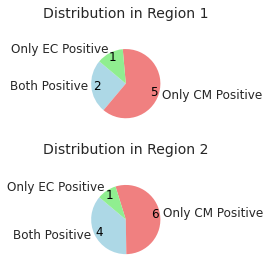

In [15]:
# Compute counts for each condition per region
counts = (
    df.assign(
        condition=pd.Categorical(
            np.select(
                [(df['CM'] > 0) & (df['EC'] > 0), (df['CM'] > 0), (df['EC'] > 0)],
                ['Both Positive', 'Only CM Positive', 'Only EC Positive'],
                default='Negative'
            )
        )
    )
    .groupby(['region', 'condition'])
    .size()
    .unstack(fill_value=0)
)

# Define plot settings
regions = [1, 2]
colors = {'Both Positive': 'lightblue', 'Only CM Positive': 'lightcoral', 'Only EC Positive': 'lightgreen'}
fig, axs = plt.subplots(2, figsize=(4, 4))

# Generate pie charts for each region
for i, region in enumerate(regions):
    sizes = counts.loc[region, ['Both Positive', 'Only CM Positive', 'Only EC Positive']]
    labels = sizes.index
    wedges, texts, autotexts = axs[i].pie(
        sizes, labels=labels, colors=[colors[label] for label in labels],
        autopct='', startangle=140, pctdistance=0.85, wedgeprops={'linewidth': 0}
    )
    axs[i].set_title(f'Distribution in Region {region}\n', fontsize=14)

    for wedge, label, count in zip(wedges, labels, sizes):
        angle = (wedge.theta2 - wedge.theta1) / 2 + wedge.theta1
        x = wedge.r * 0.85 * np.cos(np.radians(angle))  # Convert angle to radians
        y = wedge.r * 0.85 * np.sin(np.radians(angle))
        axs[i].text(x, y, f'{count}', ha='center', va='center', fontsize=12, color='black')


# Adjust layout and save/show the plot
plt.tight_layout()
plt.savefig(os.path.join(out, "piechart_regions.png"))
plt.savefig(os.path.join(out, "piechart_regions.svg"))

# Chi-square test
chi2, p, _, _ = chi2_contingency(counts.loc[regions, ['Both Positive', 'Only CM Positive', 'Only EC Positive']])
print(f"Chi-square statistic: {chi2:.2f}, p-value: {p:.3g}")


## All techniques combined. Tamoxifen (retrospecitve) + TAT-Cre (prospective) + Live-imaging

In [16]:
df = combined

### Figure 4B
#### Matrix showing the Jaccard similarity score between the different cell types studied with chi-square annotated on them

To analyze the lineage relationship between cardiomyocytes, endocardial cells and
other embryonic compartments, we calculated the Jaccard similarity score for each possible
combination. That is the number of clones that contain both types
of cells divided by the total number of clones that contain any of the types alone or
together. This revealed that CMs and ECs do not appear together often; instead, CMs
are more related to other splanchnic mesoderm. Also, ECs appeared more frequently
together with other endothelial types than with CMs

- https://www.statisticshowto.com/jaccard-index/
- https://www.statology.org/jaccard-similarity/

Apply to all the possible combinations in the summary dataframe to create a similarity matrix that we can later use to plot a heatmap

Representing correlation between cell types. Cuincidence of cell types in the same cluster regardless of the number because we convert all positive values to 1

In [17]:
# Select numerical columns and binarize
columns_to_plot = ['CM', 'EC', 'EmM', 'EmEt', 'ExEt', 'ExM']
clusters_summary_num = df[columns_to_plot].fillna(0)
clusters_summary_num = np.where(clusters_summary_num > 0, 1, 0)

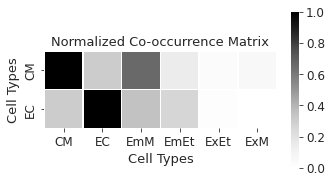

In [18]:
# Compute Jaccard similarity matrix
matrix = pd.DataFrame(np.zeros((len(columns_to_plot), len(columns_to_plot))),
                      index=columns_to_plot, columns=columns_to_plot)

for col1, col2 in combinations_with_replacement(columns_to_plot, 2):
    intersection = np.sum((clusters_summary_num[:, columns_to_plot.index(col1)] == 1) &
                          (clusters_summary_num[:, columns_to_plot.index(col2)] == 1))
    union = np.sum((clusters_summary_num[:, columns_to_plot.index(col1)] == 1) |
                   (clusters_summary_num[:, columns_to_plot.index(col2)] == 1))
    
    jaccard = intersection / union if union > 0 else 0
    matrix.loc[col1, col2] = matrix.loc[col2, col1] = jaccard  # Symmetric matrix

# Subset to show only CM and EC comparisons
matrix = matrix.loc[['CM', 'EC']]

# Plot heatmap
plt.figure(figsize=(5, 2.8))
sns.heatmap(matrix, cmap="Greys", linewidths=0.5, square=True)

# Labels and title
plt.title("Normalized Co-occurrence Matrix")
plt.xlabel("Cell Types")
plt.ylabel("Cell Types")

# Set correct tick labels
plt.xticks(ticks=np.arange(0.5, matrix.shape[1] + 0.5), labels=matrix.columns)
plt.yticks(ticks=np.arange(0.5, matrix.shape[0] + 0.5), labels=matrix.index)

# Save the figure
plt.savefig(os.path.join(out, "Jaccard_heatmap_corrected.svg"))
plt.savefig(os.path.join(out, "Jaccard_heatmap_corrected.png"))

In [19]:
matrix

,CM,EC,EmM,EmEt,ExEt,ExM
CM,1.00000,0.31068,0.662651,0.151163,0.037037,0.061728
EC,0.31068,1.00000,0.353659,0.263158,0.017857,0.000000


### Figure 4D

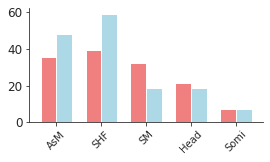

In [64]:
# Define groups
group_1 = df.query("CM > 0 and EC == 0 and EmM > 0")
group_2 = df.query("CM > 0 and EC > 0 and EmM > 0")

# Columns to analyze
subtype_columns = ['AsM', 'SHF', 'SM', 'Head', 'Somi']

# Calculate percentages
percentages_df = pd.DataFrame({
    'Group: CM > 0, EC = 0': (group_1[subtype_columns] > 0).mean() * 100,
    'Group: CM > 0, EC > 0': (group_2[subtype_columns] > 0).mean() * 100
})

# Plot
fig, ax = plt.subplots(figsize=(4, 2.5))
percentages_df.plot.bar(color=['lightcoral', 'lightblue'], width=0.7, ax=ax)

# Customize appearance
ax.set_ylabel('')
ax.set_xticklabels(percentages_df.index, rotation=45, fontsize=10)
plt.legend([], [], frameon=False)  # Hide legend

sns.despine(ax=ax)  # Remove top and right spines

# Save figure
plt.savefig(os.path.join(out, "Proportion_EmM_clones.svg"))
plt.savefig(os.path.join(out, "Proportion_EmM_clones.png"))



### PCA similarity between cell types
Not included in the manuscript. This attemps to test how similar are cell types in terms of lineage similarity. Instead of pair-wise comparisons, all-to-all

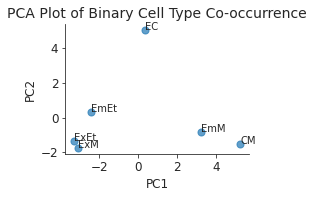

In [63]:
# Select relevant columns (main celltypes) and binarize data
binary_df = (df[['CM', 'EC', 'EmM', 'EmEt', 'ExEt', 'ExM']] != 0).astype(int)

# Perform PCA on the transposed DataFrame
pca = PCA(n_components=2)
pca_result = pca.fit_transform(binary_df.T)

# Plot PCA
plt.figure(figsize=(4.45, 3))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7, s=50)

# Annotate points
for i, cell_type in enumerate(binary_df.columns):
    plt.annotate(cell_type, (pca_result[i, 0], pca_result[i, 1]), fontsize=10)

# Customize plot aesthetics
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
plt.title('PCA Plot of Binary Cell Type Co-occurrence', fontsize=14)

ax = plt.gca()
# Loop over spines
for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)

plt.grid(False)
plt.tight_layout()

# Save figure
plt.savefig(os.path.join(out, "PCA_celltypes_all_data_clonal_merged.png"))
